# TCC Augusto e Ícaro
## Clusterização de textos classificados pelo corpus gerado na v0.3.0 do modelo

* Versão 0.3.0
* Bibliotecas utilizadas: pandas, numpy, texthero, ntlk e corpus do ntlk em português
* Dataset utilizado: dataset_v9.csv
* Data: 09-07-2020

### Objetivos, incrementos e correções:

* Encapsulamento da pipeline de pre-processamento
* Utilizando dataset com classificação revisada para melhor acurácia
* Aumento dos pesos de termos classificados como usabilidade
* Foco em detalhar e evoluir o dicionário de radicais classificados

In [1]:
import sys
!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install texthero 
!{sys.executable} -m pip install nltk
!{sys.executable} -m pip install sklearn

Requirement already up-to-date: pip in /home/icaro/.pyenv/versions/3.7.3/lib/python3.7/site-packages (20.2.1)


In [1]:
import pandas as pd
import texthero as hero
import nltk
from nltk.corpus import stopwords
import numpy as np
# nltk.download()

In [2]:
DROPLIST_FILENAME='droplist.0.2.0.txt'
MODEL_FILENAME='models/model_v0.3.0.json'
DATASET_SENTIMENTS_FILENAME='datasets/reviews_with_sentiments_31-08-2020.csv'
DATASET_CLASSIFIED_FILENAME='datasets/reviews_v9.csv'

In [3]:
def pre_process(df):
    df['text'] = hero.preprocessing.clean(df['text'])
    pt_stopwords = stopwords.words('portuguese')
    df['text'] = hero.remove_stopwords(df['text'], stopwords=pt_stopwords)
    df['text'] = hero.stem(df['text'], language='portuguese')
    df['text'] = hero.tokenize(df['text'])
    try:
        df['class_name'] = df.apply(lambda row: 'usability' if row['is_usability'] else 'not_usability', axis=1)
        df = df.drop('is_usability', 1)
    except:
        df['class_name'] = pd.Series(dtype='str')
    return df    

In [4]:
def classificate(corpus, sentence):
    def calculate_class_score(corpus_words, sentence, class_name):
        score = 0 
        for word in sentence:
            if word in corpus_words[class_name]:
                score += corpus_words[class_name][word]
        return score
    classifications = []
    for class_name in corpus.keys():
        classifications.append({'class_name': class_name, 'score': calculate_class_score(corpus, sentence, class_name)})    
    return classifications

In [5]:
def normalize_scores(classification):
    total_score = sum(score['score'] for score in classification['scores'])
    if total_score != 0:
        for score in classification['scores']:
            score['score'] = score['score']/total_score
    return classification

In [6]:
def drop_unwanted_words(corpus, droplist):
    filtered_dict = {}
    for k in corpus.keys():
        filtered_dict.update({k: { key:value for (key,value) in corpus[k].items() if key not in droplist }})
    return filtered_dict

In [56]:
df_sentiments =  pd.read_csv(DATASET_SENTIMENTS_FILENAME, index_col=False, usecols=['ID', 'Text', 'Sentiment'])
df_heuristics =  pd.read_csv(DATASET_CLASSIFIED_FILENAME, index_col=False, usecols=['ID', 'Text', 'is_usability', 'is_classified'])

In [57]:
import json
corpus = {}
with open(MODEL_FILENAME) as f:
  corpus = json.load(f)

In [58]:
df_heuristics

,ID,Text,is_usability,is_classified
0,gp:AOqpTOGQYqUxy0wRIy5v-ZwXfMcNn_nF4FiKbB5rwnp...,Ok,False,True
1,gp:AOqpTOG9KAw8pd1bk9SAiCG427z_uVCb_TJB-ihNXjx...,Hh,False,True
2,gp:AOqpTOEJ-tdSvp09Dvg3_81aTiDuhPPW9RKp5RtmAjc...,Ok,False,True
3,gp:AOqpTOGCAu9M166-MbVWhpmNh8LagaNeva-mS5aY-VQ...,Top,False,True
4,gp:AOqpTOH-TkxBfhnIzr1Jqm9y42DJBdWeYlcbnrXPOhY...,Boa,False,True
...,...,...,...,...
925,gp:AOqpTOGaoRHM_nm5_HTUJ0KGpZhibNWU3yEM2PSPQJw...,O link que foi informado está quebrado ou não ...,True,True
926,gp:AOqpTOFa6Uc8lHM7NUgRXC7UOfyqJ_vu7qCX_PP43lH...,Tô dando uma estrela pq é pra poder fazer o fe...,True,True
927,gp:AOqpTOGeoH5Ek6vAxA-Q6eBmZv-wHZvQ6-oD6OvWP2k...,"Não funciona, não consigo recuperar minha senh...",True,True
928,gp:AOqpTOESrJg3FZ1w0rSaWjvug_qBWjv8b2XrLpCqbBX...,site péssimo estou tentando a 1 mês tentado en...,True,True


In [59]:
df_sentiments

,ID,Sentiment,Text
0,gp:AOqpTOHZ9b0kCWnytlK-YJh44a9E1GSfAeolQXeg0i-...,positive,Não consigo imprimir o boleto para fazer o ene...
1,gp:AOqpTOGwGfpYa5XpPGL68q_P8LR2HAlWkWtGGtRa70F...,negative,Péssimo. Vocês poderiam facilitar a recuperaçã...
2,gp:AOqpTOG-7wpB8tAPlaoqyNm2aA4NQHxvJt-skZClHoS...,neutral,N consigo fazer nada e ñ chego nem o email pra...
3,gp:AOqpTOEdwiop-vwzzF1_0nvas56N2zwdpf3fMF9fwOD...,negative,"App péssimo, não tem como criar uma conta, da ..."
4,gp:AOqpTOEQCKKKvGsEmMY4lgcgA2V8JaIK1JT9siidOOo...,negative,Orivel esse app 😠😡😡💩
...,...,...,...
1330,gp:AOqpTOFN0MQte5XyWSHw-sAkDm4dVhXcKvr_MINUIDP...,positive,Bom
1331,gp:AOqpTOG-7hZzRYjQ2YWy_e0IJuBs876YWtvXe2mbgCa...,neutral,Finalmente minha pátrica se digitaliza!
1332,gp:AOqpTOEkFvC8miL7mlwhIYWrxPANQOEQNs75fEZyq75...,neutral,É UM LIXXXXXXXOOOOOOOOO
1333,gp:AOqpTOGW-qVe3vXmyxMniDA8ozU6hosukg-g8RbzSEc...,neutral,Não funciona.


In [88]:
merged_dataset = pd.merge(df_sentiments, df_heuristics, on="ID", how='outer')
merged_dataset

,ID,Sentiment,Text_x,Text_y,is_usability,is_classified
0,gp:AOqpTOHZ9b0kCWnytlK-YJh44a9E1GSfAeolQXeg0i-...,positive,Não consigo imprimir o boleto para fazer o ene...,Não consigo imprimir o boleto para fazer o ene...,True,True
1,gp:AOqpTOGwGfpYa5XpPGL68q_P8LR2HAlWkWtGGtRa70F...,negative,Péssimo. Vocês poderiam facilitar a recuperaçã...,Péssimo. Vocês poderiam facilitar a recuperaçã...,True,True
2,gp:AOqpTOG-7wpB8tAPlaoqyNm2aA4NQHxvJt-skZClHoS...,neutral,N consigo fazer nada e ñ chego nem o email pra...,N consigo fazer nada e ñ chego nem o email pra...,True,True
3,gp:AOqpTOEdwiop-vwzzF1_0nvas56N2zwdpf3fMF9fwOD...,negative,"App péssimo, não tem como criar uma conta, da ...","App péssimo, não tem como criar uma conta, da ...",True,True
4,gp:AOqpTOEQCKKKvGsEmMY4lgcgA2V8JaIK1JT9siidOOo...,negative,Orivel esse app 😠😡😡💩,Orivel esse app 😠😡😡💩,False,True
...,...,...,...,...,...,...
1330,gp:AOqpTOFN0MQte5XyWSHw-sAkDm4dVhXcKvr_MINUIDP...,positive,Bom,NaN,NaN,NaN
1331,gp:AOqpTOG-7hZzRYjQ2YWy_e0IJuBs876YWtvXe2mbgCa...,neutral,Finalmente minha pátrica se digitaliza!,NaN,NaN,NaN
1332,gp:AOqpTOEkFvC8miL7mlwhIYWrxPANQOEQNs75fEZyq75...,neutral,É UM LIXXXXXXXOOOOOOOOO,NaN,NaN,NaN
1333,gp:AOqpTOGW-qVe3vXmyxMniDA8ozU6hosukg-g8RbzSEc...,neutral,Não funciona.,NaN,NaN,NaN


In [89]:
merged_dataset = merged_dataset.drop(columns=['Text_y'])
merged_dataset = merged_dataset.rename(columns={'Text_x': 'text', 'ID': 'id', 'Sentiment': 'sentiment'})

In [90]:
merged_dataset['is_classified'] = merged_dataset['is_classified'].fillna(value=False)
merged_dataset

,id,sentiment,text,is_usability,is_classified
0,gp:AOqpTOHZ9b0kCWnytlK-YJh44a9E1GSfAeolQXeg0i-...,positive,Não consigo imprimir o boleto para fazer o ene...,True,True
1,gp:AOqpTOGwGfpYa5XpPGL68q_P8LR2HAlWkWtGGtRa70F...,negative,Péssimo. Vocês poderiam facilitar a recuperaçã...,True,True
2,gp:AOqpTOG-7wpB8tAPlaoqyNm2aA4NQHxvJt-skZClHoS...,neutral,N consigo fazer nada e ñ chego nem o email pra...,True,True
3,gp:AOqpTOEdwiop-vwzzF1_0nvas56N2zwdpf3fMF9fwOD...,negative,"App péssimo, não tem como criar uma conta, da ...",True,True
4,gp:AOqpTOEQCKKKvGsEmMY4lgcgA2V8JaIK1JT9siidOOo...,negative,Orivel esse app 😠😡😡💩,False,True
...,...,...,...,...,...
1330,gp:AOqpTOFN0MQte5XyWSHw-sAkDm4dVhXcKvr_MINUIDP...,positive,Bom,NaN,False
1331,gp:AOqpTOG-7hZzRYjQ2YWy_e0IJuBs876YWtvXe2mbgCa...,neutral,Finalmente minha pátrica se digitaliza!,NaN,False
1332,gp:AOqpTOEkFvC8miL7mlwhIYWrxPANQOEQNs75fEZyq75...,neutral,É UM LIXXXXXXXOOOOOOOOO,NaN,False
1333,gp:AOqpTOGW-qVe3vXmyxMniDA8ozU6hosukg-g8RbzSEc...,neutral,Não funciona.,NaN,False


In [94]:
orig_merged_dataset = merged_dataset.copy()
pre_processed_dataset = pre_process(merged_dataset)
pre_processed_dataset

,id,sentiment,text,is_classified,class_name
0,gp:AOqpTOHZ9b0kCWnytlK-YJh44a9E1GSfAeolQXeg0i-...,positive,"[nao, consig, imprim, bolet, faz, enem, inscre...",True,usability
1,gp:AOqpTOGwGfpYa5XpPGL68q_P8LR2HAlWkWtGGtRa70F...,negative,"[pessim, voc, pod, facilit, recuperaca, senh, ...",True,usability
2,gp:AOqpTOG-7wpB8tAPlaoqyNm2aA4NQHxvJt-skZClHoS...,neutral,"[n, consig, faz, nad, n, cheg, email, pra, mim]",True,usability
3,gp:AOqpTOEdwiop-vwzzF1_0nvas56N2zwdpf3fMF9fwOD...,negative,"[app, pessim, nao, cri, cont, erro, temp, tod,...",True,usability
4,gp:AOqpTOEQCKKKvGsEmMY4lgcgA2V8JaIK1JT9siidOOo...,negative,"[orivel, app]",True,not_usability
...,...,...,...,...,...
1330,gp:AOqpTOFN0MQte5XyWSHw-sAkDm4dVhXcKvr_MINUIDP...,positive,[bom],False,usability
1331,gp:AOqpTOG-7hZzRYjQ2YWy_e0IJuBs876YWtvXe2mbgCa...,neutral,"[final, patric, digitaliz]",False,usability
1332,gp:AOqpTOEkFvC8miL7mlwhIYWrxPANQOEQNs75fEZyq75...,neutral,[lixxxxxxxoooooooo],False,usability
1333,gp:AOqpTOGW-qVe3vXmyxMniDA8ozU6hosukg-g8RbzSEc...,neutral,"[nao, funcion]",False,usability


In [95]:
orig_merged_dataset

,id,sentiment,text,is_usability,is_classified
0,gp:AOqpTOHZ9b0kCWnytlK-YJh44a9E1GSfAeolQXeg0i-...,positive,Não consigo imprimir o boleto para fazer o ene...,True,True
1,gp:AOqpTOGwGfpYa5XpPGL68q_P8LR2HAlWkWtGGtRa70F...,negative,Péssimo. Vocês poderiam facilitar a recuperaçã...,True,True
2,gp:AOqpTOG-7wpB8tAPlaoqyNm2aA4NQHxvJt-skZClHoS...,neutral,N consigo fazer nada e ñ chego nem o email pra...,True,True
3,gp:AOqpTOEdwiop-vwzzF1_0nvas56N2zwdpf3fMF9fwOD...,negative,"App péssimo, não tem como criar uma conta, da ...",True,True
4,gp:AOqpTOEQCKKKvGsEmMY4lgcgA2V8JaIK1JT9siidOOo...,negative,Orivel esse app 😠😡😡💩,False,True
...,...,...,...,...,...
1330,gp:AOqpTOFN0MQte5XyWSHw-sAkDm4dVhXcKvr_MINUIDP...,positive,Bom,NaN,False
1331,gp:AOqpTOG-7hZzRYjQ2YWy_e0IJuBs876YWtvXe2mbgCa...,neutral,Finalmente minha pátrica se digitaliza!,NaN,False
1332,gp:AOqpTOEkFvC8miL7mlwhIYWrxPANQOEQNs75fEZyq75...,neutral,É UM LIXXXXXXXOOOOOOOOO,NaN,False
1333,gp:AOqpTOGW-qVe3vXmyxMniDA8ozU6hosukg-g8RbzSEc...,neutral,Não funciona.,NaN,False


In [96]:
pre_processed_dataset_dict = pre_processed_dataset.to_dict('records')
orig_merged_dataset_dict = orig_merged_dataset.to_dict('records')
for data in pre_processed_dataset_dict:
    if not data['is_classified']:
        classifications = {'scores': classificate(corpus, data['text'])}
        classifications = normalize_scores(classifications)
        highest_score = max(classifications['scores'], key=lambda x:x['score'])
        data['class_name'] = highest_score['class_name']
len(pre_processed_dataset_dict)

1335

In [130]:
documents = []
usability_dataset_dict = []
for i, w in enumerate(pre_processed_dataset_dict):
    if(w['class_name'] == 'usability'):
#     if(w['class_name'] == 'usability' and w['sentiment'] in ['negative', 'neutral']):
        documents.append(' '.join(w['text']))
        usability_dataset_dict.append(orig_merged_dataset_dict[i])
#         print(orig_merged_dataset_dict[w])
#         print(w)
len(documents)

1032

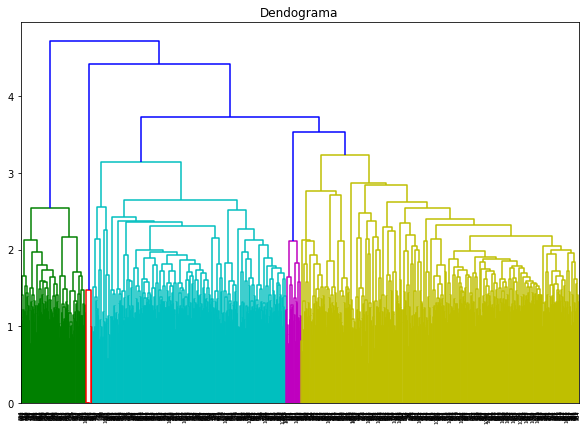

In [66]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(documents)

plt.figure(figsize=(10, 7))
plt.title("Dendograma")
dend = dendrogram(linkage(X.toarray(), method='ward'))

In [67]:
print(len(set(dend['color_list'])))

6


In [114]:
n_clusters=5
cluster = AgglomerativeClustering(n_clusters, affinity='euclidean', linkage='ward')
Y = cluster.fit_predict(X.toarray())
centroide = {}
for i in range(n_clusters):
    centroide[i] = {}
    cluster_words_indexes = np.where(Y == i)
    for cw in cluster_words_indexes:
        for w in cw:
            for palavra in documents[w].split():
                if palavra not in list(centroide[i].keys()):
                    centroide[i][palavra] = 1
                else:
                    centroide[i][palavra] += 1
droplist = open(DROPLIST_FILENAME).read().splitlines()
centroide = drop_unwanted_words(centroide, droplist)

def calculate_cluster_score(centroide, sentence, number):
        score = 0 
        for word in sentence:
            if word in centroide[number]:
                score += centroide[number][word]
        return score

scored_sentences = {}
for i in range(n_clusters):
    scored_sentences[i] = []
    cluster_words_indexes = np.where(Y == i)
    for cw in cluster_words_indexes:
        for w in cw:
            score = calculate_cluster_score(centroide, documents[w].split(), i)
            scored_sentences[i].append({'score': score, 'text': documents[w], 'id': usability_dataset_dict[w]['id']})

In [142]:
top_5_scores = {}
for k in scored_sentences.keys():
    sort = sorted(scored_sentences[k], key=lambda k: k['score'], reverse=True)
    top_5_scores[k] = sort[:5]
    print('----------------')
    print(f'Cluster {k}: ')
    print('--')
    for idx, item in enumerate(top_5_scores[k]):
        original_item = [d for d in usability_dataset_dict if d['id']==item['id']][0]
        print(f' Frase {idx}:  {original_item["text"]}')
        print('--')

----------------
Cluster 0: 
--
 Frase 0:  Aplicativo inútil, a cada ano que passa complicam mais ainda o acesso à prova, além da taxa cara e absurda, ainda inventam esse aplicativo que não funciona, estou desde que abriu a inscrição tentando acessar e nada até agora pois não consigo definir a senha novamente, pedem vinculação de perguntas serem respondidas mas não tem a opção de redefinir a senha. Aplicativo ridículo, inútil totalmente inútil. O site nem e fala, pq pede nos direciona ao aplicativo.
--
 Frase 1:  O aplicativo é ridiculo, o reconhecimento facial não funciona. Ele simplismente te faz de idiota, e fica mandando você olhar para a esquerda e para a direita, e quando manda fechar os olhos ele te manda fazer mais alguma ação e quando você abre os olhos para ler, ele manda fechar os olhos novamente, quem consegue ler de olhos fechados? Aplicativo burro, não presta. Além de tudo, é solicitado a data da emissão da última CNH, coloquei a data informada no DETRAN, e o aplicativo d

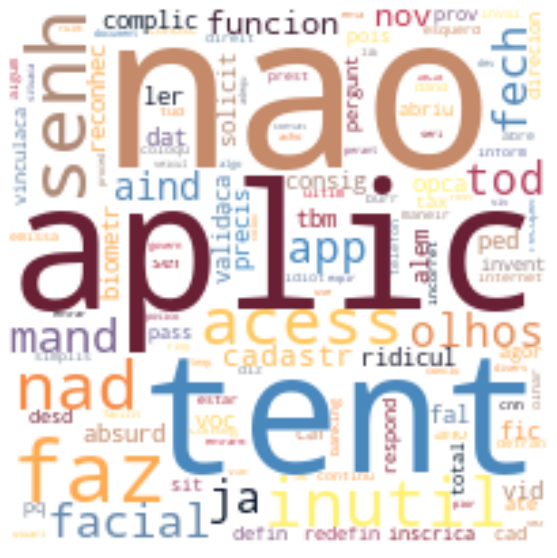

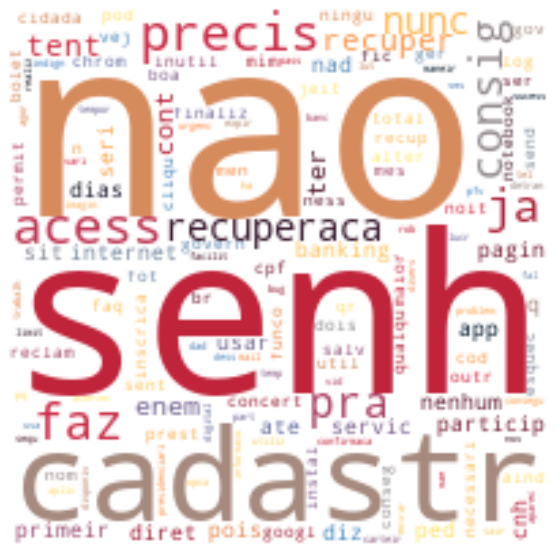

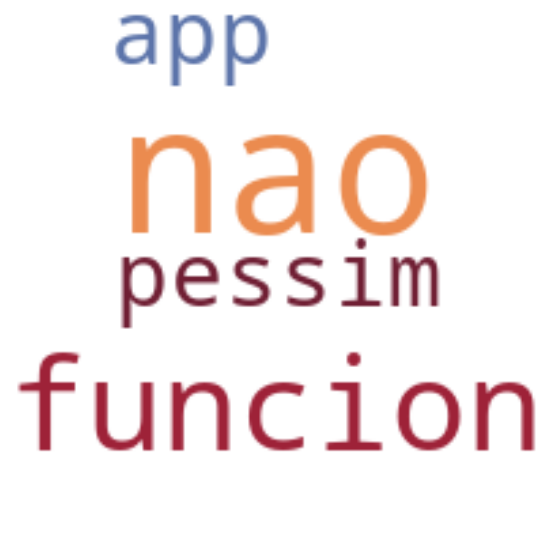

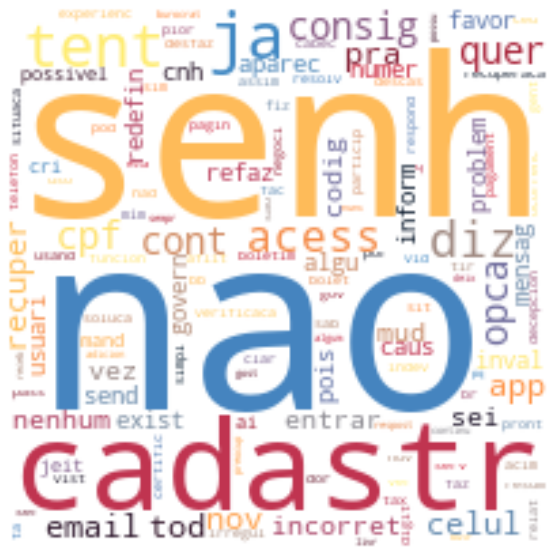

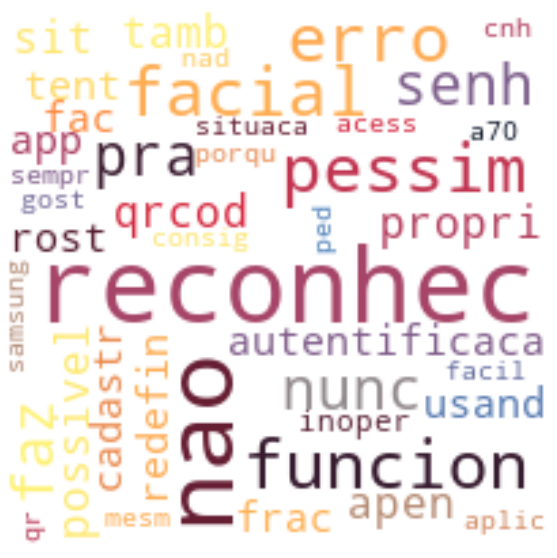

In [137]:
top_5_scores_joined = {}
for k in scored_sentences.keys():
    sort = sorted(scored_sentences[k], key=lambda k: k['score'], reverse=True) 
    top_5_scores[k] = ' '.join([item['text'] for item in sort[:5]])
    hero.wordcloud(pd.Series(top_5_scores[k]), width=200, height=200, background_color='white')